In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from model_spec import model_spec
from pol_model import load_bands, model_p, get_a_b
from scipy.optimize import minimize, LinearConstraint

In [2]:
#The measured values in each band. 
p_measured = np.array([0.0973, 0.1085, 0.1466])
p_unc = np.array([0.0037, 0.0023, 0.0041])

## Model the SDSS Spectrum

In [3]:
spec, model = model_spec()

In [4]:
#Assume that Lyman alpha is also polarized in the same manner as all the other emission lines. 
model.multi_line[0].pol = True
model.multi_line[1].pol = True

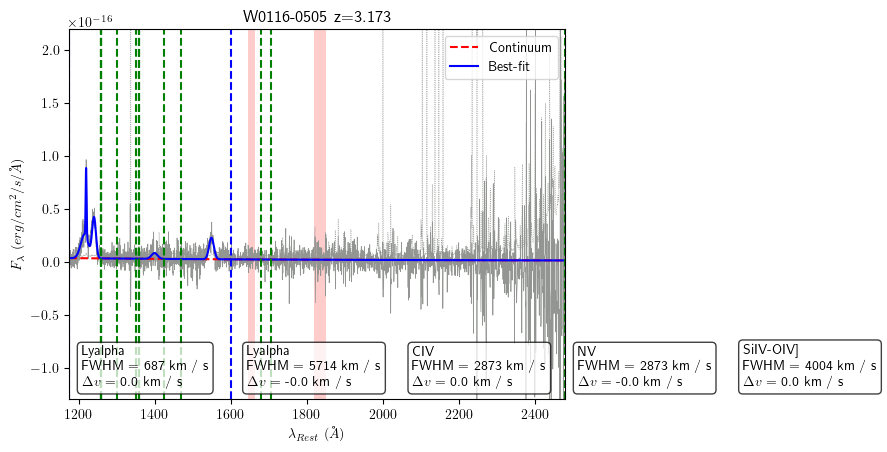

In [5]:
model.plot()

## Model the Broad-band polarizations

In [6]:
bands = load_bands()

### Unconstrained Pure Gas Fit

In [7]:
#This is the polarization function for gas. Namely, it is not a function of wavelength.
#theta = lambda lam : 1.0
theta = np.ones(len(spec.lam_rest))

In [8]:
a, b = get_a_b(theta, theta, bands, spec, model)

In [9]:
def chi2(x, a, b):
    p_mod = np.zeros(3)
    for j in range(3):
        p_mod[j] = model_p(x, a[j], b[j])
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [10]:
x0 = np.array([0.13, 0.35, 50.])
G = np.identity(x0.shape[0])
min_vals = [0., 0., 0.]
max_vals = [1., 1., 360.]
lincon = LinearConstraint(G, min_vals, max_vals)
xopt = minimize(chi2, x0=x0, constraints=lincon, args=(a,b))
print(xopt)
for j in range(3):
    print(model_p(xopt.x, a[j], b[j]))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.9837660076982815
       x: [ 1.373e-01  7.227e-02  2.830e-04]
     nit: 24
     jac: [ 7.185e-02 -4.047e-02  1.937e-06]
    nfev: 102
    njev: 24
0.09989443739371424
0.10623968762599609
0.14957440456867477


Text(0, 0.5, 'Polarization fraction')

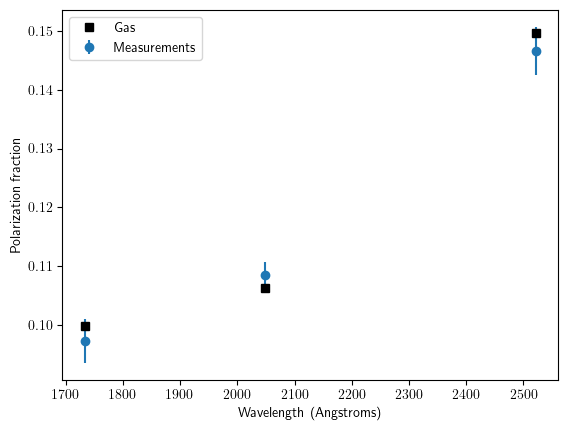

In [11]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec
plt.errorbar(wave, p_measured, yerr=p_unc, fmt='o', label='Measurements')
mod_p = np.zeros(3)
for j in range(3):
    mod_p[j] = model_p(xopt.x, a[j], b[j])
plt.plot(wave, mod_p, 'ks', label='Gas')
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Polarization fraction')

### Gas Fit with pol Requirement

Here we require that the emission lines and the continuum have the same polarization fraction. 

In [12]:
def chi2(x, a, b):
    p_mod = np.zeros(3)
    for j in range(3):
        x_for_model_p = [x[0], x[0], x[1]]
        p_mod[j] = model_p(x_for_model_p, a[j], b[j])
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [13]:
x0 = np.array([0.13, 50.])
G = np.identity(x0.shape[0])
min_vals = [0., 0.]
max_vals = [1., 360.]
lincon = LinearConstraint(G, min_vals, max_vals)
xopt = minimize(chi2, x0=x0, constraints=lincon, args=(a,b))
print(xopt)
for j in range(3):
    x_for_model_p = [xopt.x[0], xopt.x[0], xopt.x[1]]
    print(model_p(x_for_model_p, a[j], b[j]))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 15.374054228324928
       x: [ 1.384e-01  3.826e+01]
     nit: 7
     jac: [-2.649e-01  1.551e-04]
    nfev: 24
    njev: 7
0.10784300607824271
0.1026194090950923
0.15007294097698676


Text(0, 0.5, 'Polarization fraction')

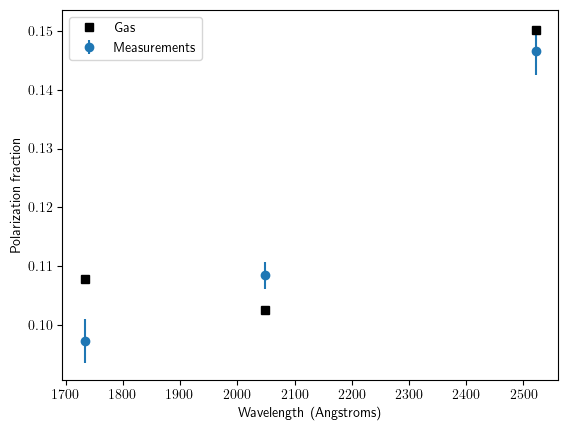

In [14]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec
plt.errorbar(wave, p_measured, yerr=p_unc, fmt='o', label='Measurements')
mod_p = np.zeros(3)
for j in range(3):
    x_for_model_p = [xopt.x[0], xopt.x[0], xopt.x[1]]
    mod_p[j] = model_p(x_for_model_p, a[j], b[j])
plt.plot(wave, mod_p, 'ks', label='Gas')
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Polarization fraction')